## Lab 2: Sentiment Analysis in Apache Spark

GOH JING YANG A22EC0052


In [92]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [93]:
# Create SparkSession
print("Creating SparkSession...")
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .master("local[*]") \
    .getOrCreate()
print("SparkSession created successfully")

Creating SparkSession...
SparkSession created successfully


In [94]:
# Load the dataset
data = spark.read.csv("data.csv", header=True, inferSchema=True)
print("Dataset loaded successfully")

Dataset loaded successfully


In [95]:
data.show()

+--------------------+---------+
|            Sentence|Sentiment|
+--------------------+---------+
|The GeoSolutions ...| positive|
|$ESI on lows, dow...| negative|
|For the last quar...| positive|
|According to the ...|  neutral|
|The Swedish buyou...|  neutral|
|$SPY wouldn't be ...| positive|
|Shell's $70 Billi...| negative|
|SSH COMMUNICATION...| negative|
|Kone 's net sales...| positive|
|The Stockmann dep...|  neutral|
|Circulation reven...| positive|
|$SAP Q1 disappoin...| negative|
|The subdivision m...| positive|
|Viking Line has c...|  neutral|
|Ahlstrom Corporat...|  neutral|
|$FB gone green on...| positive|
|$MSFT SQL Server ...| positive|
|According to L+ñn...|  neutral|
|The company 's sh...|  neutral|
|Elcoteq SE is lis...|  neutral|
+--------------------+---------+
only showing top 20 rows


In [96]:
# Clean up the data (remove quotes from Sentence column if present)
data = data.withColumn("Sentence", regexp_replace(col("Sentence"), "^\"|\"$", ""))

In [97]:
# Show sample data
print("\nSample data from the dataset:")
data.show(10, truncate=False)


Sample data from the dataset:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|Sentence                                                                                                                                                                                                                  |Sentiment|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .|positive |
|$ESI on lows, down $1.50 to $2.50 BK a real 

In [98]:
# Map text-based sentiment values to numeric values
print("\nMapping sentiment labels to numeric values...")
data = data.withColumn(
    "label", 
    when(col("Sentiment") == "negative", 0.0)  # Negative sentiment
    .when(col("Sentiment") == "neutral", 1.0)  # Neutral sentiment
    .when(col("Sentiment") == "positive", 2.0)  # Positive sentiment
    .otherwise(1.0)  # Default to neutral
)


Mapping sentiment labels to numeric values...


In [99]:
# Show original data
print("\nOriginal Text Data:")
data.select("Sentence", "Sentiment").show(truncate=False)

# Step 1: Basic tokenization - Split text into words
print("\n--- Step 1: Basic Tokenization ---")
print("Splitting text into individual words (tokens)...")

# Create tokenizer
tokenizer = Tokenizer(inputCol="Sentence", outputCol="words")
tokenized_data = tokenizer.transform(data)

# Show tokenized data
print("\nText after basic tokenization:")
tokenized_data.select("Sentence", "words").show(truncate=False)


Original Text Data:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|Sentence                                                                                                                                                                                                                       |Sentiment|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .     |positive |
|$ESI on lows, down $1.50 to $2.50 

In [100]:
# Step 2: Remove stop words
print("\n--- Step 2: Remove Stop Words ---")
print("Stop words are common words like 'the', 'a', 'an', 'in' that don't carry much meaning")

# Get the default stop words list
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
default_stop_words = remover.getStopWords()

print(f"\nNumber of default stop words: {len(default_stop_words)}")
print("Sample of default stop words:")
print(default_stop_words[:20])

# Apply stop words removal
filtered_data = remover.transform(tokenized_data)

# Show data after stop word removal
print("\nText after stop words removal:")
filtered_data.select("Sentence", "words", "filtered_words").show(truncate=False)

# Compare word counts before and after stop word removal
print("\n--- Word Count Comparison ---")
from pyspark.sql.functions import size

# Add word count columns using built-in size function
tokenized_with_count = tokenized_data.withColumn("word_count", size(col("words")))
filtered_with_count = filtered_data.withColumn("filtered_word_count", size(col("filtered_words")))

# Join the two dataframes to compare counts
comparison = tokenized_with_count.select("Sentence", "word_count").join(
    filtered_with_count.select("Sentence", "filtered_word_count"),
    "Sentence"
)

print("Word count before and after stop word removal:")
comparison.select("Sentence", "word_count", "filtered_word_count", 
                 (col("word_count") - col("filtered_word_count")).alias("words_removed")).show(truncate=False)


--- Step 2: Remove Stop Words ---
Stop words are common words like 'the', 'a', 'an', 'in' that don't carry much meaning

Number of default stop words: 181
Sample of default stop words:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers']

Text after stop words removal:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------

In [101]:
# Step 3: Convert text to numerical features using CountVectorizer
print("\n--- Converting Text to Numerical Features ---")
print("Using CountVectorizer to convert filtered words into feature vectors")

# Create CountVectorizer
cv = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)

# Fit the CountVectorizer to learn vocabulary
cv_model = cv.fit(filtered_data)

# Get the vocabulary 
vocabulary = cv_model.vocabulary
print(f"\nVocabulary size: {len(vocabulary)} words")
print(f"Sample of vocabulary (first 10 words): {vocabulary[:10]}")

# Transform the data to get feature vectors
vectorized_data = cv_model.transform(filtered_data)

# Examine the first feature vector
first_vector = vectorized_data.select("features").first()[0]
print(f"\nShape of feature vector: {len(first_vector.indices)} non-zero features out of {len(vocabulary)} total features")
print(f"This is a sparse vector representation with {first_vector.numNonzeros()} non-zero entries")

# Display feature vectors
print("\nFeature vectors (sparse representation):")
vectorized_data.select("Sentence", "features").show(truncate=False)


--- Converting Text to Numerical Features ---
Using CountVectorizer to convert filtered words into feature vectors

Vocabulary size: 13961 words
Sample of vocabulary (first 10 words): ['.', ',', 'eur', "'s", 'company', 'mn', 'profit', 'sales', ')', '(']

Shape of feature vector: 22 non-zero features out of 13961 total features
This is a sparse vector representation with 22 non-zero entries

Feature vectors (sparse representation):
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentence                                                                                                                                           

In [102]:
# Step 4: Split data into training and testing sets
print("\n--- Step 4: Split Data into Training and Testing Sets (80/20 Split) ---")

# First, let's recreate vectorized_data without the problematic UDF column
# We'll use the clean vectorized_data from the CountVectorizer step
clean_vectorized_data = cv_model.transform(filtered_data)

print("\nMethod Using randomSplit function")
train_data, test_data = clean_vectorized_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training data size: {train_data.count()} records ({train_data.count() / clean_vectorized_data.count():.1%})")
print(f"Testing data size: {test_data.count()} records ({test_data.count() / clean_vectorized_data.count():.1%})")

# Update vectorized_data to use the clean version for future operations
vectorized_data = clean_vectorized_data


--- Step 4: Split Data into Training and Testing Sets (80/20 Split) ---

Method Using randomSplit function
Training data size: 4725 records (80.9%)
Testing data size: 1117 records (19.1%)


In [103]:
# STEP 5: Train and evaluate the improved Logistic Regression model
print("\n--- STEP 5: Logistic Regression Model Training and Evaluation ---")

# Create a LogisticRegression object
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Train the model on the training data
model = lr.fit(train_data)

# Use the trained model to make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Show confusion matrix information
print("\nPrediction vs Actual Label Distribution:")
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

# Show classification metrics for each class
print("\nClassification Report:")
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
    result = evaluator.evaluate(predictions)
    print(f"{metric.capitalize()}: {result:.4f}")


--- STEP 5: Logistic Regression Model Training and Evaluation ---

Model Accuracy: 0.6025 (60.25%)

Prediction vs Actual Label Distribution:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   31|
|  0.0|       1.0|  109|
|  0.0|       2.0|   22|
|  1.0|       0.0|  110|
|  1.0|       1.0|  432|
|  1.0|       2.0|  103|
|  2.0|       0.0|   28|
|  2.0|       1.0|   72|
|  2.0|       2.0|  210|
+-----+----------+-----+


Classification Report:
Accuracy: 0.6025
Weightedprecision: 0.6075
Weightedrecall: 0.6025
F1: 0.6045


In [104]:
# IMPROVEMENT 1: Enhanced text preprocessing
print("\n--- IMPROVEMENT 1: Enhanced Text Preprocessing ---")
from pyspark.sql.functions import lower, regexp_replace, trim, length

# Enhanced data cleaning
data_clean = data.withColumn("Sentence", lower(col("Sentence"))) \
                 .withColumn("Sentence", regexp_replace(col("Sentence"), r"[^\w\s]", "")) \
                 .withColumn("Sentence", regexp_replace(col("Sentence"), r"\d+", "")) \
                 .withColumn("Sentence", trim(col("Sentence"))) \
                 .filter(length(col("Sentence")) > 10)  # Remove very short sentences
print("Enhanced preprocessing applied: lowercase, punctuation removal, number removal, trimming")

# IMPROVEMENT 2: Custom stop words for financial sentiment
print("\n--- IMPROVEMENT 2: Custom Stop Words for Financial Data ---")

# Add financial-specific stop words
financial_stop_words = [
    "eur", "usd", "million", "billion", "company", "said", "today", "announced",
    "finnish", "finland", "year", "quarter", "period", "compared", "versus"
]

# Combine with default stop words
custom_stop_words = StopWordsRemover.loadDefaultStopWords("english") + financial_stop_words

# Create enhanced stop words remover
enhanced_remover = StopWordsRemover(
    inputCol="words", 
    outputCol="filtered_words",
    stopWords=custom_stop_words
)

print(f"Using {len(custom_stop_words)} stop words (including {len(financial_stop_words)} financial-specific)")

# IMPROVEMENT 3: Enhanced feature extraction with TF-IDF
print("\n--- IMPROVEMENT 3: TF-IDF Feature Extraction ---")

from pyspark.ml.feature import HashingTF, IDF

# Apply enhanced preprocessing
tokenizer = Tokenizer(inputCol="Sentence", outputCol="words")
tokenized_clean = tokenizer.transform(data_clean)
filtered_clean = enhanced_remover.transform(tokenized_clean)

# Use HashingTF instead of CountVectorizer for better feature space
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
featurized_data = hashingTF.transform(filtered_clean)

# Apply IDF to get TF-IDF features
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)

print("TF-IDF features created with 10,000-dimensional feature space")

# IMPROVEMENT 4: Balanced dataset split with stratification
print("\n--- IMPROVEMENT 4: Balanced Train-Test Split ---")

# Check class distribution
print("Original class distribution:")
tfidf_data.groupBy("label").count().orderBy("label").show()

# Create stratified split manually
negative_data = tfidf_data.filter(col("label") == 0.0)
neutral_data = tfidf_data.filter(col("label") == 1.0)
positive_data = tfidf_data.filter(col("label") == 2.0)

# Split each class separately
neg_train, neg_test = negative_data.randomSplit([0.8, 0.2], seed=42)
neu_train, neu_test = neutral_data.randomSplit([0.8, 0.2], seed=42)
pos_train, pos_test = positive_data.randomSplit([0.8, 0.2], seed=42)

# Combine splits
train_balanced = neg_train.union(neu_train).union(pos_train)
test_balanced = neg_test.union(neu_test).union(pos_test)

print(f"Balanced training set: {train_balanced.count()} samples")
print(f"Balanced test set: {test_balanced.count()} samples")

print("Training set class distribution:")
train_balanced.groupBy("label").count().orderBy("label").show()

# IMPROVEMENT 5: Advanced Logistic Regression with better hyperparameters
print("\n--- IMPROVEMENT 5: Optimized Logistic Regression ---")

# Create optimized LogisticRegression
lr_optimized = LogisticRegression(
    labelCol="label", 
    featuresCol="features",
    maxIter=200,              # More iterations
    regParam=0.01,            # Lower regularization
    elasticNetParam=0.8,      # More L1 regularization for feature selection
    family="multinomial",
    standardization=True,     # Standardize features
    threshold=0.4             # Adjust decision threshold
)

# Train the optimized model
print("Training optimized Logistic Regression model...")
model_optimized = lr_optimized.fit(train_balanced)
print("Optimized model training completed!")

# Make predictions
predictions_optimized = model_optimized.transform(test_balanced)

# Evaluate optimized model
accuracy_optimized = evaluator.evaluate(predictions_optimized)
print(f"\nOptimized Model Accuracy: {accuracy_optimized:.4f} ({accuracy_optimized*100:.2f}%)")

# IMPROVEMENT 8: Detailed evaluation metrics
print("\n--- IMPROVEMENT 8: Comprehensive Model Evaluation ---")

def evaluate_model_comprehensive(predictions, model_name):
    print(f"\n{model_name} - Detailed Metrics:")
    
    # Calculate all metrics
    metrics_dict = {}
    for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
        evaluator_metric = MulticlassClassificationEvaluator(
            labelCol="label", 
            predictionCol="prediction", 
            metricName=metric
        )
        result = evaluator_metric.evaluate(predictions)
        metrics_dict[metric] = result
        print(f"{metric.capitalize()}: {result:.4f}")
    
    # Confusion matrix
    print(f"\n{model_name} - Confusion Matrix:")
    predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()
    
    return metrics_dict

# Evaluate all models
original_metrics = evaluate_model_comprehensive(predictions, "Original Model")
optimized_metrics = evaluate_model_comprehensive(predictions_optimized, "Optimized Logistic Regression")

# IMPROVEMENT 9: Model comparison summary
print("\n--- IMPROVEMENT 9: Model Comparison Summary ---")
print("=" * 80)
print(f"{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("=" * 80)
print(f"{'Original LR':<25} {original_metrics['accuracy']:<12.4f} {original_metrics['weightedPrecision']:<12.4f} {original_metrics['weightedRecall']:<12.4f} {original_metrics['f1']:<12.4f}")
print(f"{'Optimized LR':<25} {optimized_metrics['accuracy']:<12.4f} {optimized_metrics['weightedPrecision']:<12.4f} {optimized_metrics['weightedRecall']:<12.4f} {optimized_metrics['f1']:<12.4f}")


# Calculate improvement
improvement = (optimized_metrics['accuracy'] - original_metrics['accuracy']) * 100
print(f"\nImprovement over original model: {improvement:.2f} percentage points")




--- IMPROVEMENT 1: Enhanced Text Preprocessing ---
Enhanced preprocessing applied: lowercase, punctuation removal, number removal, trimming

--- IMPROVEMENT 2: Custom Stop Words for Financial Data ---
Using 196 stop words (including 15 financial-specific)

--- IMPROVEMENT 3: TF-IDF Feature Extraction ---
TF-IDF features created with 10,000-dimensional feature space

--- IMPROVEMENT 4: Balanced Train-Test Split ---
Original class distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|  859|
|  1.0| 3128|
|  2.0| 1846|
+-----+-----+

Balanced training set: 4799 samples
Balanced test set: 1034 samples
Training set class distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|  721|
|  1.0| 2554|
|  2.0| 1524|
+-----+-----+


--- IMPROVEMENT 5: Optimized Logistic Regression ---
Training optimized Logistic Regression model...
Optimized model training completed!

Optimized Model Accuracy: 0.6725 (67.25%)

--- IMPROVEMENT 8: Comprehensive Model Evaluation ---

Original Model -

In [105]:
# Convert the confusion matrix to a Pandas DataFrame
confusion_matrix = predictions.groupBy("label", "prediction").count().toPandas()
# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix)



Confusion Matrix:
   label  prediction  count
0    2.0         0.0     28
1    1.0         1.0    432
2    0.0         1.0    109
3    2.0         2.0    210
4    1.0         0.0    110
5    2.0         1.0     72
6    1.0         2.0    103
7    0.0         0.0     31
8    0.0         2.0     22


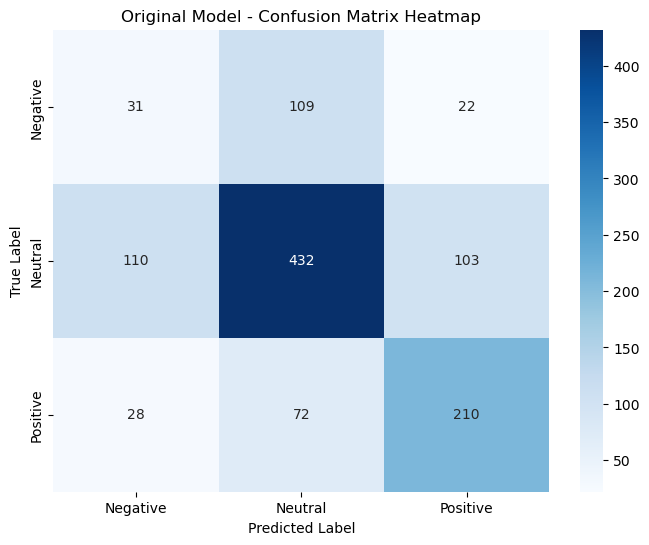

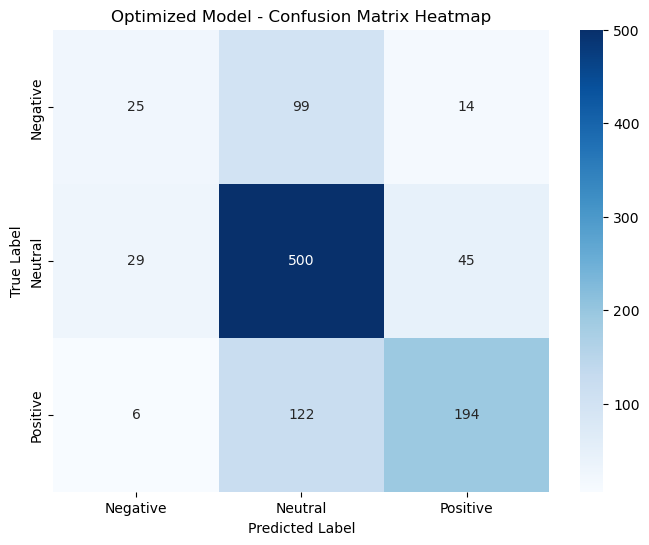

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the confusion matrix to a Pandas DataFrame
confusion_matrix = predictions.groupBy("label", "prediction").count().toPandas()

# Create pivot table for the heatmap
pivot_matrix = confusion_matrix.pivot(index="label", columns="prediction", values="count")

# Fill any missing values with 0
pivot_matrix = pivot_matrix.fillna(0)

# Map numeric labels to sentiment names
label_mapping = {0.0: 'Negative', 1.0: 'Neutral', 2.0: 'Positive'}
pivot_matrix.index = pivot_matrix.index.map(label_mapping)
pivot_matrix.columns = pivot_matrix.columns.map(label_mapping)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_matrix, annot=True, fmt="g", cmap="Blues")
plt.title("Original Model - Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
# Also create heatmap for optimized model
confusion_matrix_opt = predictions_optimized.groupBy("label", "prediction").count().toPandas()
pivot_matrix_opt = confusion_matrix_opt.pivot(index="label", columns="prediction", values="count")
pivot_matrix_opt = pivot_matrix_opt.fillna(0)

# Map numeric labels to sentiment names for optimized model
pivot_matrix_opt.index = pivot_matrix_opt.index.map(label_mapping)
pivot_matrix_opt.columns = pivot_matrix_opt.columns.map(label_mapping)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_matrix_opt, annot=True, fmt="g", cmap="Blues")
plt.title("Optimized Model - Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [107]:
# Stop the Spark session
print("\nStopping Spark session...")
spark.stop()



Stopping Spark session...
